<a href="https://colab.research.google.com/github/VarelAntoni/machine_learning_project/blob/main/score_credit_prediction/Home_Credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, RocCurveDisplay
import matplotlib.pyplot as plt

In [30]:
# Membaca file utama
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
pos_cash = pd.read_csv("POS_CASH_balance.csv")
credit_card = pd.read_csv("credit_card_balance.csv")
previous_app = pd.read_csv("previous_application.csv")
installments = pd.read_csv("installments_payments.csv")

In [31]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
def preprocess_and_merge(train, bureau, bureau_balance):
    # Aggregate bureau_balance
    # Convert 'MONTHS_BALANCE' to numeric, errors='coerce' will replace non-numeric values with NaN
    bureau_balance['MONTHS_BALANCE'] = pd.to_numeric(bureau_balance['MONTHS_BALANCE'], errors='coerce')
    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': ['min', 'max', 'mean'],
        'STATUS': 'nunique'  # Example aggregation
    }).reset_index()
    bureau_balance_agg.columns = ['SK_ID_BUREAU'] + ['_'.join(col) for col in bureau_balance_agg.columns[1:]]

    # Merge bureau and bureau_balance
    bureau_merged = pd.merge(bureau, bureau_balance_agg, on='SK_ID_BUREAU', how='left')

    # Aggregate bureau to SK_ID_CURR level
    bureau_agg = bureau_merged.groupby('SK_ID_CURR').agg({
        'CREDIT_ACTIVE': 'count',
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'AMT_CREDIT_SUM': ['sum', 'mean']
    }).reset_index()
    bureau_agg.columns = ['SK_ID_CURR'] + ['_'.join(col) for col in bureau_agg.columns[1:]]

    # Merge with application_train
    final_data = pd.merge(train, bureau_agg, on='SK_ID_CURR', how='left')

    return final_data

In [33]:
# Process and merge data
merged_data = preprocess_and_merge(train, bureau, bureau_balance)

In [34]:
merged_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE_count,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,8.0,-1437.0,-103.0,-874.00,865055.565,108131.945625
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,4.0,-2586.0,-606.0,-1400.75,1017400.500,254350.125000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,2.0,-1326.0,-408.0,-867.00,189037.800,94518.900000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,1.0,-1149.0,-1149.0,-1149.00,146250.000,146250.000000


In [35]:
# Handling missing values with mode
def fill_missing_with_mode(merged_data):
    for column in merged_data.columns:
        if merged_data[column].isnull().sum() > 0:
            mode_value = merged_data[column].mode()[0]
            merged_data[column].fillna(mode_value, inplace=True)
fill_missing_with_mode(merged_data)

<ipython-input-35-b98e542b3663>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[column].fillna(mode_value, inplace=True)


In [37]:
print(merged_data.info('object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 128 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [36]:
# Handling duplicates
merged_data.drop_duplicates(inplace=True)

In [38]:
merged_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE_count,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,8.0,-1437.0,-103.0,-874.00,865055.565,108131.945625
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,4.0,-2586.0,-606.0,-1400.75,1017400.500,254350.125000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,2.0,-1326.0,-408.0,-867.00,189037.800,94518.900000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.0,-2919.0,-91.0,-441.00,225000.000,225000.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,1.0,-1149.0,-1149.0,-1149.00,146250.000,146250.000000


In [39]:
# Prepare data for modeling
X = merged_data.drop(columns=['TARGET',
                              'SK_ID_CURR'])
y = merged_data['TARGET']

In [40]:
# Identify categorical columns and encode them
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [41]:
print(y.value_counts())

TARGET
0    282686
1     24825
Name: count, dtype: int64


In [42]:
merged_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE_count,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,8.0,-1437.0,-103.0,-874.00,865055.565,108131.945625
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,4.0,-2586.0,-606.0,-1400.75,1017400.500,254350.125000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,2.0,-1326.0,-408.0,-867.00,189037.800,94518.900000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.0,-2919.0,-91.0,-441.00,225000.000,225000.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,1.0,-1149.0,-1149.0,-1149.00,146250.000,146250.000000


In [43]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [44]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [45]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply one-hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align train and test datasets (to ensure the same columns)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [46]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [47]:
# Model 1: Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
logistic_preds = logistic_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
logistic_auc = roc_auc_score(y_test, logistic_preds)
print("Logistic Regression AUC:", logistic_auc)

Logistic Regression AUC: 0.9733642683070195


In [48]:
# Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
rf_auc = roc_auc_score(y_test, rf_preds)
print("Random Forest AUC:", rf_auc)

Random Forest AUC: 0.9804491665871825


In [50]:
# Compare Models
print("Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, logistic_model.predict(X_test)))
print("Classification Report (Logistic Regression):\n", classification_report(y_test, logistic_model.predict(X_test)))

Confusion Matrix (Logistic Regression):
 [[84603   242]
 [ 8069 76698]]
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     84845
           1       1.00      0.90      0.95     84767

    accuracy                           0.95    169612
   macro avg       0.95      0.95      0.95    169612
weighted avg       0.95      0.95      0.95    169612



In [51]:
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, rf_model.predict(X_test)))
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_model.predict(X_test)))

Confusion Matrix (Random Forest):
 [[84530   315]
 [ 7462 77305]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84845
           1       1.00      0.91      0.95     84767

    accuracy                           0.95    169612
   macro avg       0.96      0.95      0.95    169612
weighted avg       0.96      0.95      0.95    169612



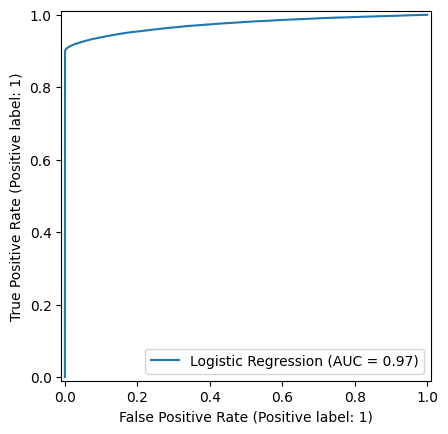

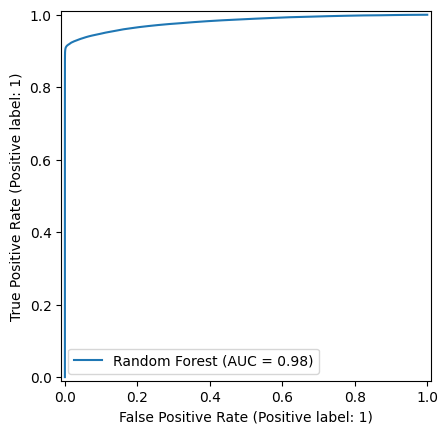

In [69]:
# ROC Curve
RocCurveDisplay.from_estimator(logistic_model, X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest")
plt.legend()
plt.show()


In [53]:
# Evaluate Precision, Recall, and F1-Score
logistic_report = classification_report(y_test, logistic_model.predict(X_test), output_dict=True)
rf_report = classification_report(y_test, rf_model.predict(X_test), output_dict=True)

# Extract relevant metrics
metrics = ['precision', 'recall', 'f1-score']
logistic_scores = [logistic_report['1'][metric] for metric in metrics]
rf_scores = [rf_report['1'][metric] for metric in metrics]

# Combine all metrics
comparison_data = pd.DataFrame({
    'Metric': ['AUC'] + metrics,
    'Logistic Regression': [logistic_auc] + logistic_scores,
    'Random Forest': [rf_auc] + rf_scores
})

<Figure size 1000x600 with 0 Axes>

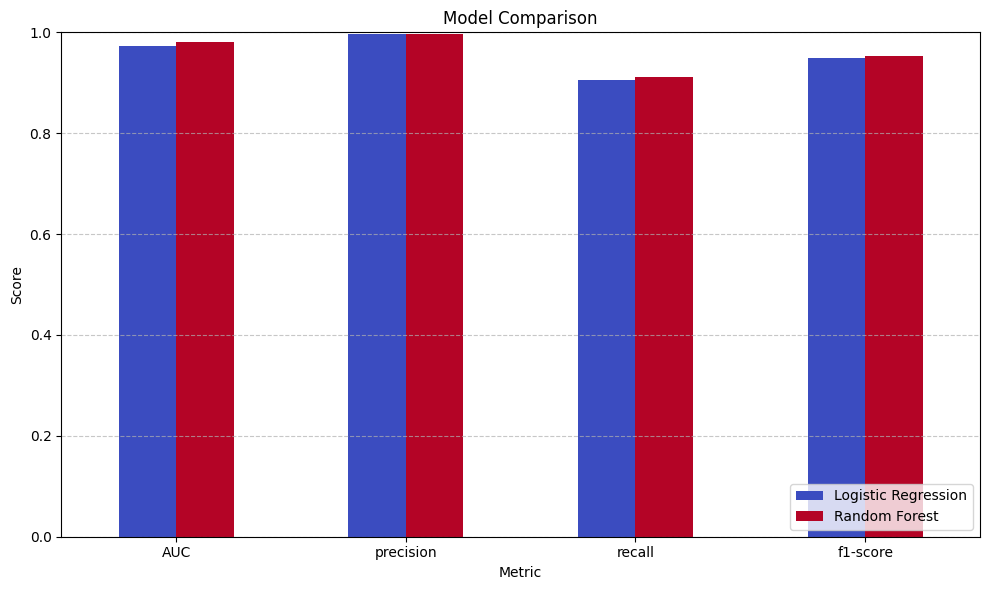

In [54]:
# Plot comparison
plt.figure(figsize=(10, 6))
comparison_data.set_index('Metric').plot(kind='bar', rot=0, figsize=(10, 6), colormap='coolwarm')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
# Basic dataset summary
print("Shape of the dataset:", merged_data.shape)
print("Columns in the dataset:\n", merged_data.columns)
print("Summary statistics:\n", merged_data.describe())
print("Missing values:\n", merged_data.isnull().sum())

Shape of the dataset: (307511, 128)
Columns in the dataset:
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'CREDIT_ACTIVE_count', 'DAYS_CREDIT_min', 'DAYS_CREDIT_max',
       'DAYS_CREDIT_mean', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_mean'],
      dtype='object', length=128)
Summary statistics:
           SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.

<ipython-input-56-9a7f0641ecdc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=merged_data, palette='coolwarm')


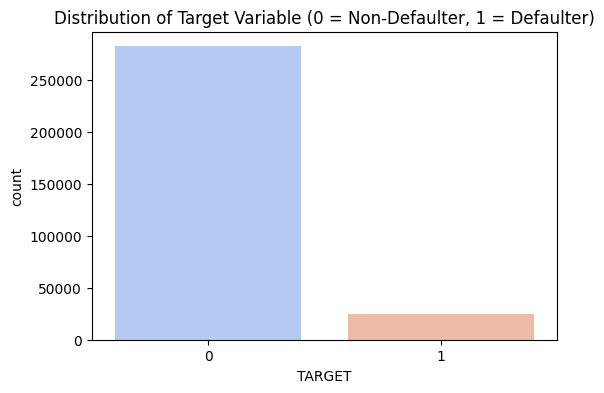

In [56]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=merged_data, palette='coolwarm')
plt.title("Distribution of Target Variable (0 = Non-Defaulter, 1 = Defaulter)")
plt.show()

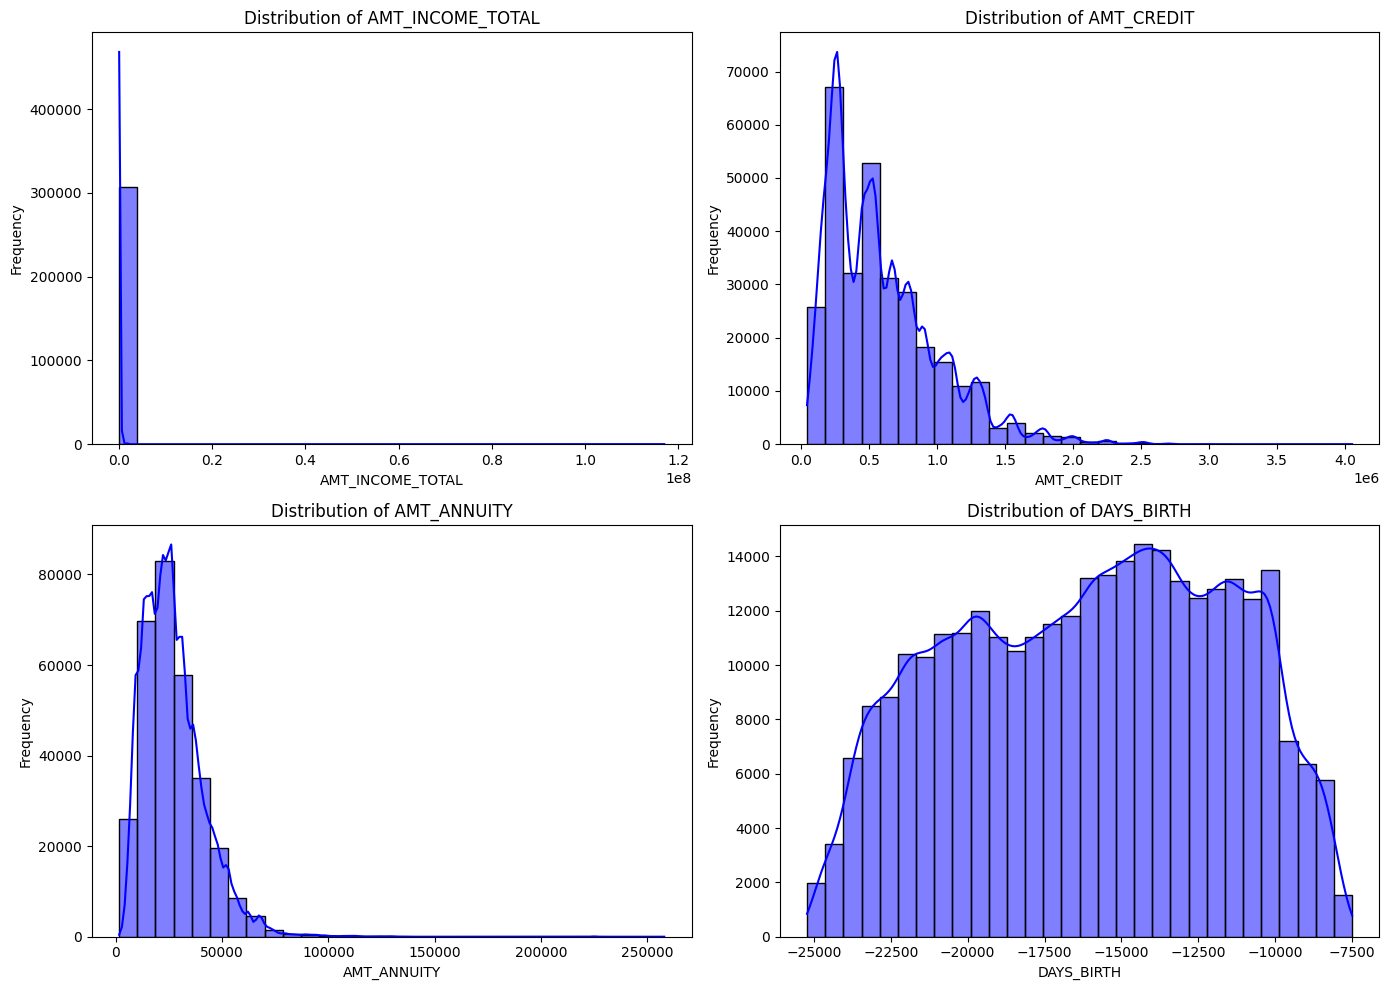

In [62]:
# Numerical columns for visualization
numerical_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH']

# Create subplots for numerical columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.histplot(data=merged_data, x=col, kde=True, bins=30, color='blue', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


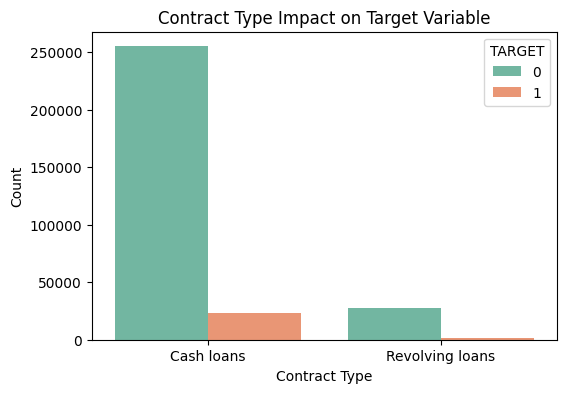

In [60]:
# Analyze categorical variable impact (e.g., NAME_CONTRACT_TYPE)
plt.figure(figsize=(6, 4))
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=merged_data, palette='Set2')
plt.title("Contract Type Impact on Target Variable")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.show()